## Some comparisons of filtering and smoothing (can be with or without the viewer)

### Hint for your task 2)
#### You must implement your filtering / smoothing in the HMMFilter / HMMSmoother classes in the file Filters. For the filter, this means also that you can use the visualisation through the Localizer, but you can call filter / smooth also directly from here, without the Localiser. Note also, that you must make use of the given models and the robot simulator in RobotSim!


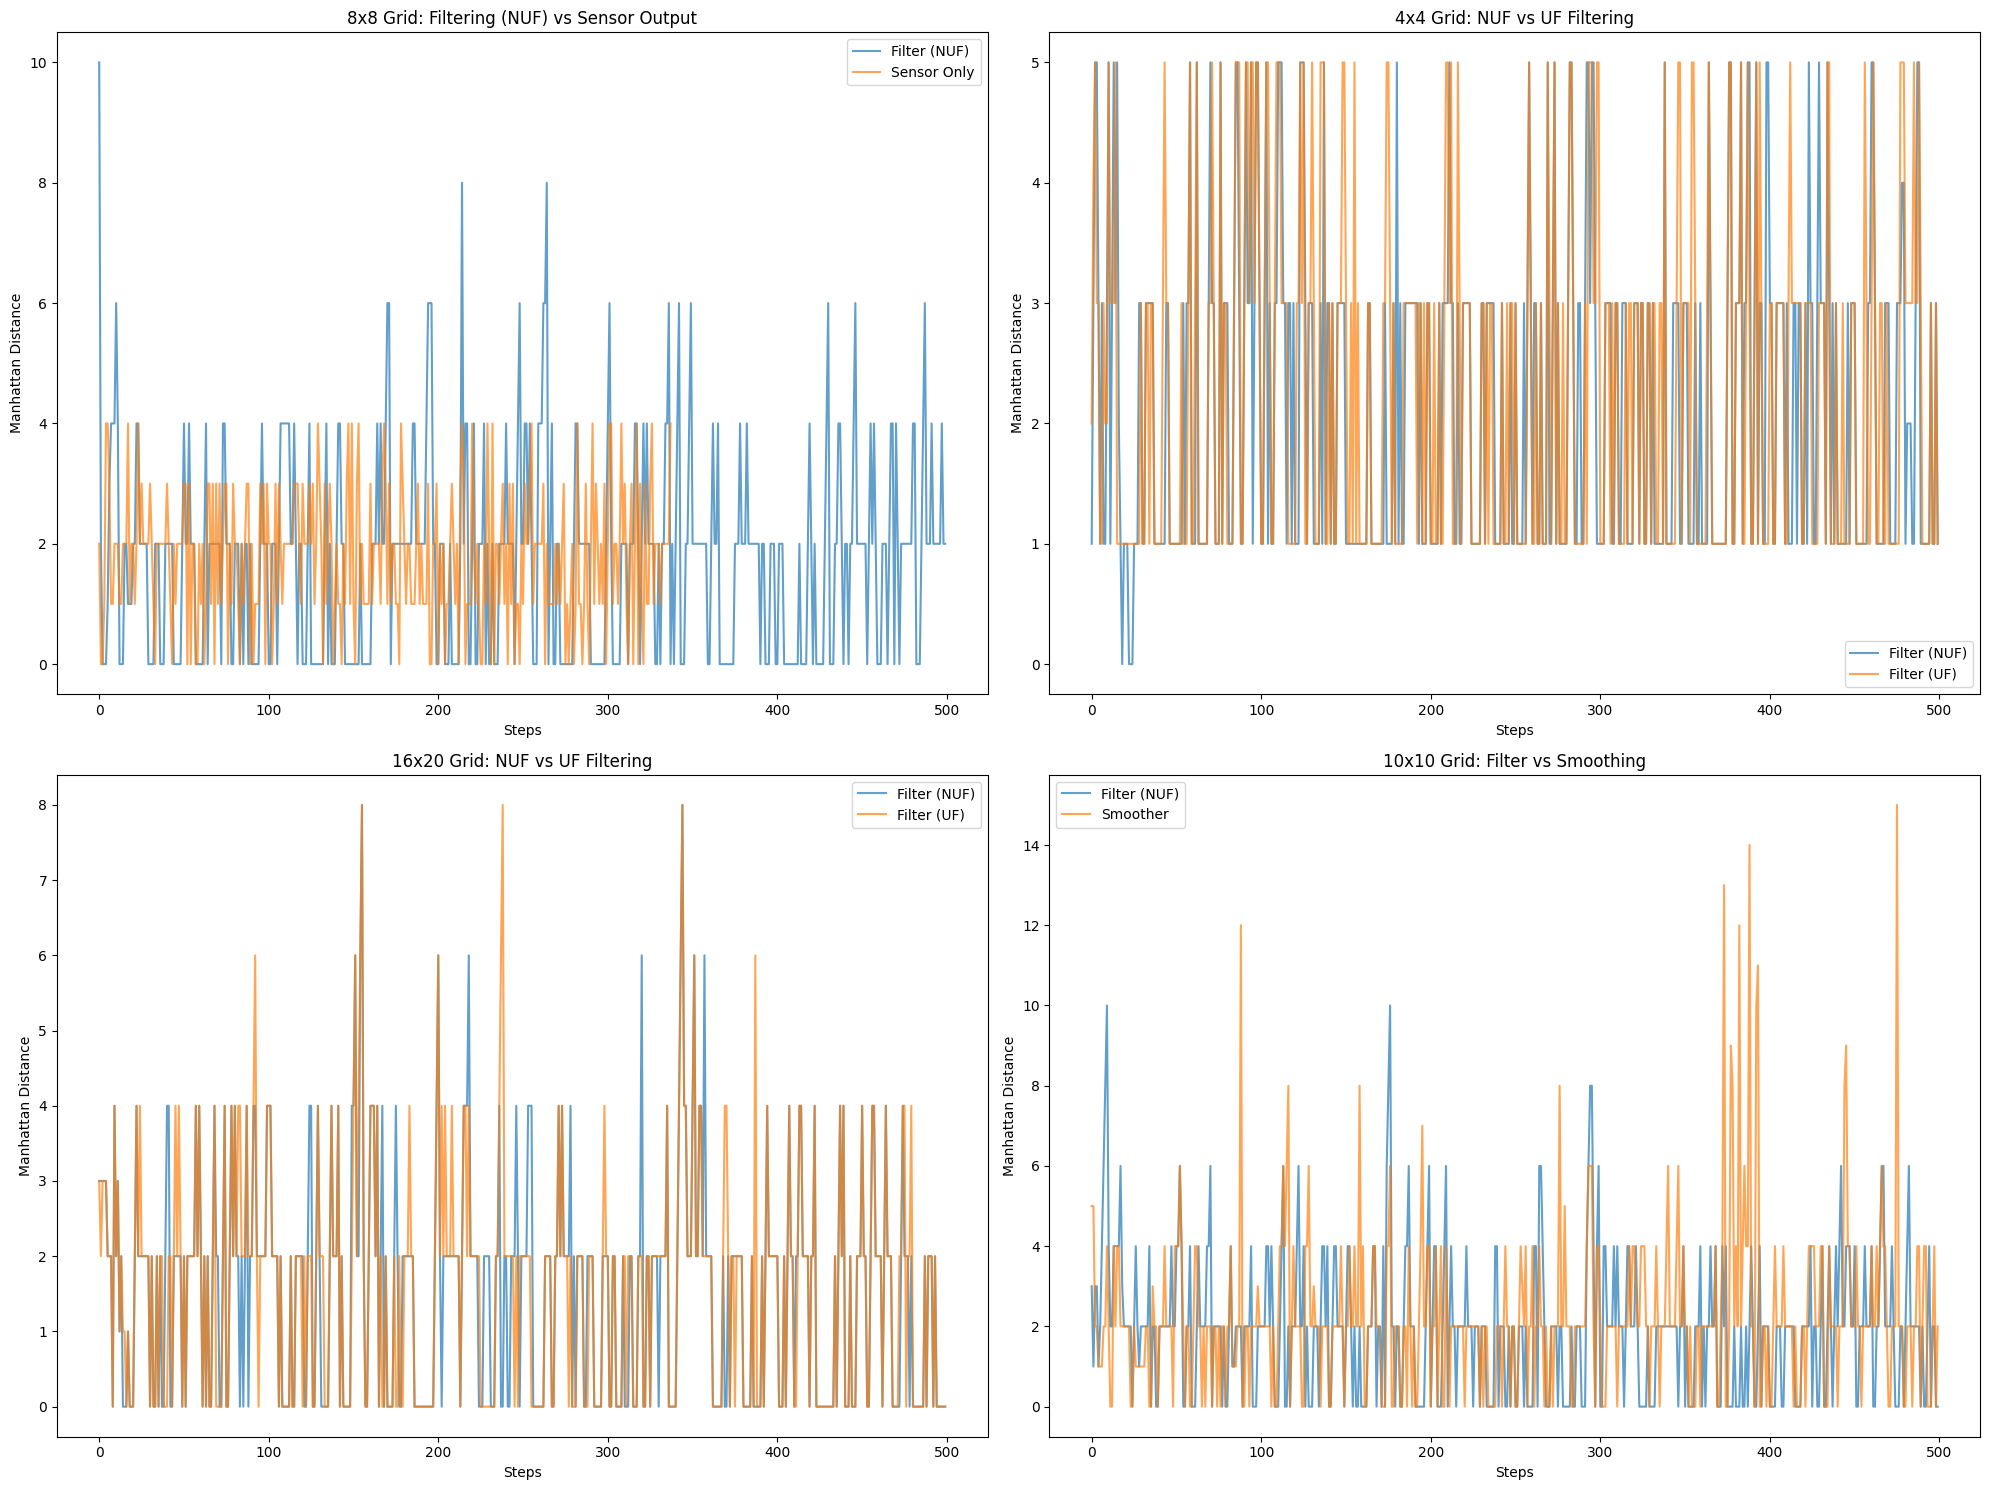


Plot 1 avg errors:
Filtering: 1.73
Sensor: 1.7692307692307692
Plot 2 avg errors:
Non-uniform filter: 2.144
Uniform filter: 2.28
Plot 3 avg errors:
Non-uniform filter: 1.564
Uniform filter: 1.59
Plot 4 avg errors:
Non-uniform filter: 1.918
Non-uniform smoother: 2.22



In [ ]:
from models import *
import importlib
from models.ObservationModel_NUF import ObservationModel as ObsModelNUF
from models.ObservationModel_UF import ObservationModelUF as ObsModelUF
import Filters
Filters = importlib.reload(Filters)
import numpy as np
import matplotlib.pyplot as plt
import random


STEPS = 500
K = 5 #(five steps for b) 

# General function that we can run the simulations on with the different settings.
def run_simulation(rows, cols, obs_model_type, use_smoothing=False, use_many_filters=False, rival_model=None, compare_sensor_only=False):

    # initialize models
    sm = StateModel(rows, cols)
    tm = TransitionModel(sm)
    om = obs_model_type(sm)
    
    # Set up filtering & smoothing
    prior = np.ones(sm.get_num_of_states()) / sm.get_num_of_states() # For NUF
    hmm_filter = Filters.HMMFilter(prior, tm, om, sm)

    if use_many_filters:
        new_prior = np.ones(sm.get_num_of_states()) * 0.1 # For UF
        rival_filter = Filters.HMMFilter(new_prior, tm, rival_model(sm), sm)
    
    # Set up simulation
    true_state = random.randint(0, sm.get_num_of_states() - 1)
    rs = RobotSim(true_state, sm)

    if use_smoothing:
        hmm_smoother = Filters.HMMSmoother(tm, om, sm, K)

        #Run tiny simulation to fill smoother_window
        for _ in range(K):
            true_state = rs.move_once(tm)
            observation = rs.sense_in_current_state(om)
            hmm_smoother.update_window(observation)

    # Set up items that we're going to use for the plots later
    filter_distances = []
    rival_filter_distances = []
    smoother_distances = []
    sensor_distances = []
    sensor_readings = []
    
    # Actual simulation!
    for _ in range(STEPS):

        # Move the robot, activate sensors
        true_state = rs.move_once(tm)
        observation = rs.sense_in_current_state(om)
        sensor_readings.append(observation)
        
        # Update filter
        filter_belief = hmm_filter.filter(observation)
        filter_estimate = sm.state_to_position(np.argmax(filter_belief))

        # Get the true position, calculate error, and store the result
        true_pos = sm.state_to_position(true_state)
        filter_dist = abs(true_pos[0] - filter_estimate[0]) + abs(true_pos[1] - filter_estimate[1])
        filter_distances.append(filter_dist)

        # Sensor-only comparison (plot 1)
        if compare_sensor_only and observation is not None:
            sensor_pos = sm.reading_to_position(observation)
            sensor_dist = abs(true_pos[0] - sensor_pos[0]) + abs(true_pos[1] - sensor_pos[1])
            sensor_distances.append(sensor_dist)

        # Filter vs Filter (plots 2 & 3)
        if use_many_filters:
            rival_belief = rival_filter.filter(observation)
            rival_estimate = sm.state_to_position(np.argmax(rival_belief))
            rival_filter_distances.append(abs(true_pos[0] - rival_estimate[0]) + abs(true_pos[1] - rival_estimate[1]))
        
        # Smoothing (plot 4)
        if use_smoothing:
            # Update the window with the current observation
            smoother_belief = hmm_smoother.smooth(filter_belief)
            smoother_estimate = sm.state_to_position(np.argmax(smoother_belief))
            smoother_dist = abs(true_pos[0] - smoother_estimate[0]) + abs(true_pos[1] - smoother_estimate[1])
            smoother_distances.append(smoother_dist)

            hmm_smoother.update_window(observation)

                
        
    return filter_distances, sensor_distances, rival_filter_distances, smoother_distances


########### Plotting settings (subplots, figures) were made with the help of Deepseek AI ###########

# Plot configurations
plt.figure(figsize=(20, 15))

# Plot 1: Forward filter, non-uniform VS sensor output (8x8)
filter_dists_nuf_8, sensor_dists_8, _, _ = run_simulation(8, 8, ObsModelNUF, compare_sensor_only=True)
plt.subplot(2, 2, 1)
plt.plot(filter_dists_nuf_8, label='Filter (NUF)', alpha=0.7)
plt.plot(sensor_dists_8, label='Sensor Only', alpha=0.7)
plt.title('8x8 Grid: Filtering (NUF) vs Sensor Output')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

# Plot 2: Forward filter, non-uniform VS Forward filter, uniform (4x4)
filter_dists_nuf_4, _, filter_dists_uf_4, _ = run_simulation(4, 4, ObsModelNUF, use_many_filters=True, rival_model=ObsModelUF)
plt.subplot(2, 2, 2)
plt.plot(filter_dists_nuf_4, label='Filter (NUF)', alpha=0.7)
plt.plot(filter_dists_uf_4, label='Filter (UF)', alpha=0.7)
plt.title('4x4 Grid: NUF vs UF Filtering')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

# Plot 3: Same settings as Plot 2, bigger grid (16x20)
filter_dists_nuf_16, _, filter_dists_uf_16, _ = run_simulation(16, 20, ObsModelNUF, use_many_filters=True, rival_model=ObsModelUF)
plt.subplot(2, 2, 3)
plt.plot(filter_dists_nuf_16, label='Filter (NUF)', alpha=0.7)
plt.plot(filter_dists_uf_16, label='Filter (UF)', alpha=0.7)
plt.title('16x20 Grid: NUF vs UF Filtering')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

# Plot 4: Forward filter, non-uniform VS FB Smoothing, non-uniform (10x10)
filter_dists_nuf_10, _, _, smoother_dists_10 = run_simulation(10, 10, ObsModelNUF, use_smoothing=True)
plt.subplot(2, 2, 4)
plt.plot(filter_dists_nuf_10, label='Filter (NUF)', alpha=0.7)
plt.plot(smoother_dists_10, label='Smoother', alpha=0.7)
plt.title('10x10 Grid: Filter vs Smoothing')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

plt.tight_layout()
plt.savefig('graph_for_report.png', bbox_inches='tight')
plt.show()

print(f"""
Plot 1 avg errors:
Filtering: {np.mean(filter_dists_nuf_8)}
Sensor: {np.mean(sensor_dists_8)}
Plot 2 avg errors:
Non-uniform filter: {np.mean(filter_dists_nuf_4)}
Uniform filter: {np.mean(filter_dists_uf_4)}
Plot 3 avg errors:
Non-uniform filter: {np.mean(filter_dists_nuf_16)}
Uniform filter: {np.mean(filter_dists_uf_16)}
Plot 4 avg errors:
Non-uniform filter: {np.mean(filter_dists_nuf_10)}
Non-uniform smoother: {np.mean(smoother_dists_10)}
""")